In [12]:
from rootpy.plotting import Hist, HistStack, Canvas, Legend
from ROOT import KinFtCM, RooArgSet
from ROOT import vector, RooRealVar, RooLognormal, RooProdPdf
from ROOT import RooFit, RooAddition, RooMinuit, RooArgList
import os
from numpy import sqrt
from rootpy.io import root_open
from rootpy.plotting import Hist, Canvas
from ROOT import TF1, TPaveText


tag_dict = { "CSVL": ["combinedSecondaryVertexBJetTags", 0.244 ],
             "CSVM": ["combinedSecondaryVertexBJetTags", 0.679 ],
             "CSVT": ["combinedSecondaryVertexBJetTags", 0.898 ],
             "JPL": ["jetProbabilityBJetTags", 0.275 ],
             "JPM": ["jetProbabilityBJetTags", 0.545 ],
             "JPT": ["jetProbabilityBJetTags", 0.79 ],
             "TCHPT" : ["trackCountingHighPurBJetTags", 3.41 ]}

In [20]:
lumi = 19789.0
s_name = "CSVM"
option = "_first"
min_tag_cat = 5000
tagger = tag_dict[s_name][0]
wp = tag_dict[s_name][1]
dir_path = "../scripts/8TeV_pt_dependent/"
json_dir = "../output/8Tev_pt_dependent/"

In [21]:
fit_status = "bfit"


data_names = ["Data_2012ABCD_Winter13_ReReco"]


mc_names = [["TTbar_Summer13", 6923750, 247.7, 0 ],
              ["WJets_Summer13", 76041475, 36257.2, 1],
              ["ZJets_Summer13", 30459503, 3503.0, 1],
              ["T_tW_Summer13", 497658, 11.15, 1],
              ["Tbar_tW_Summer13", 493460, 11.15, 1],
              ["Tbar_t_Summer13", 1935072, 30.0, 1],
              ["T_t_Summer13", 3758227, 55.531,1]]

data_samples = []
for s in data_names:
    data_samples.append([json_dir+s+".json"])

mc_samples = []
for s in mc_names:
    print json_dir+s[0]+".json"
    mc_samples.append([json_dir+s[0]+".json",s[1],s[2],s[3]])


m = KinFtCM.Builder(tagger, wp, lumi)
for mc_s in mc_samples:
    m.add_mc_component(*mc_s)
for data_s in data_samples:
    m.add_data_component(*data_s)

m.zeroNegativeFracs = False
m.useDataPretagNorm = False

# min data counts per pretag category
cats = m.add_all_categories(True,min_tag_cat)
m.set_mc_jet_tag_effs()

data = m.get_data_hist()

../output/8Tev_pt_dependent/TTbar_Summer13.json
../output/8Tev_pt_dependent/WJets_Summer13.json
../output/8Tev_pt_dependent/ZJets_Summer13.json
../output/8Tev_pt_dependent/T_tW_Summer13.json
../output/8Tev_pt_dependent/Tbar_tW_Summer13.json
../output/8Tev_pt_dependent/Tbar_t_Summer13.json
../output/8Tev_pt_dependent/T_t_Summer13.json


In [37]:
cats.size()

7L

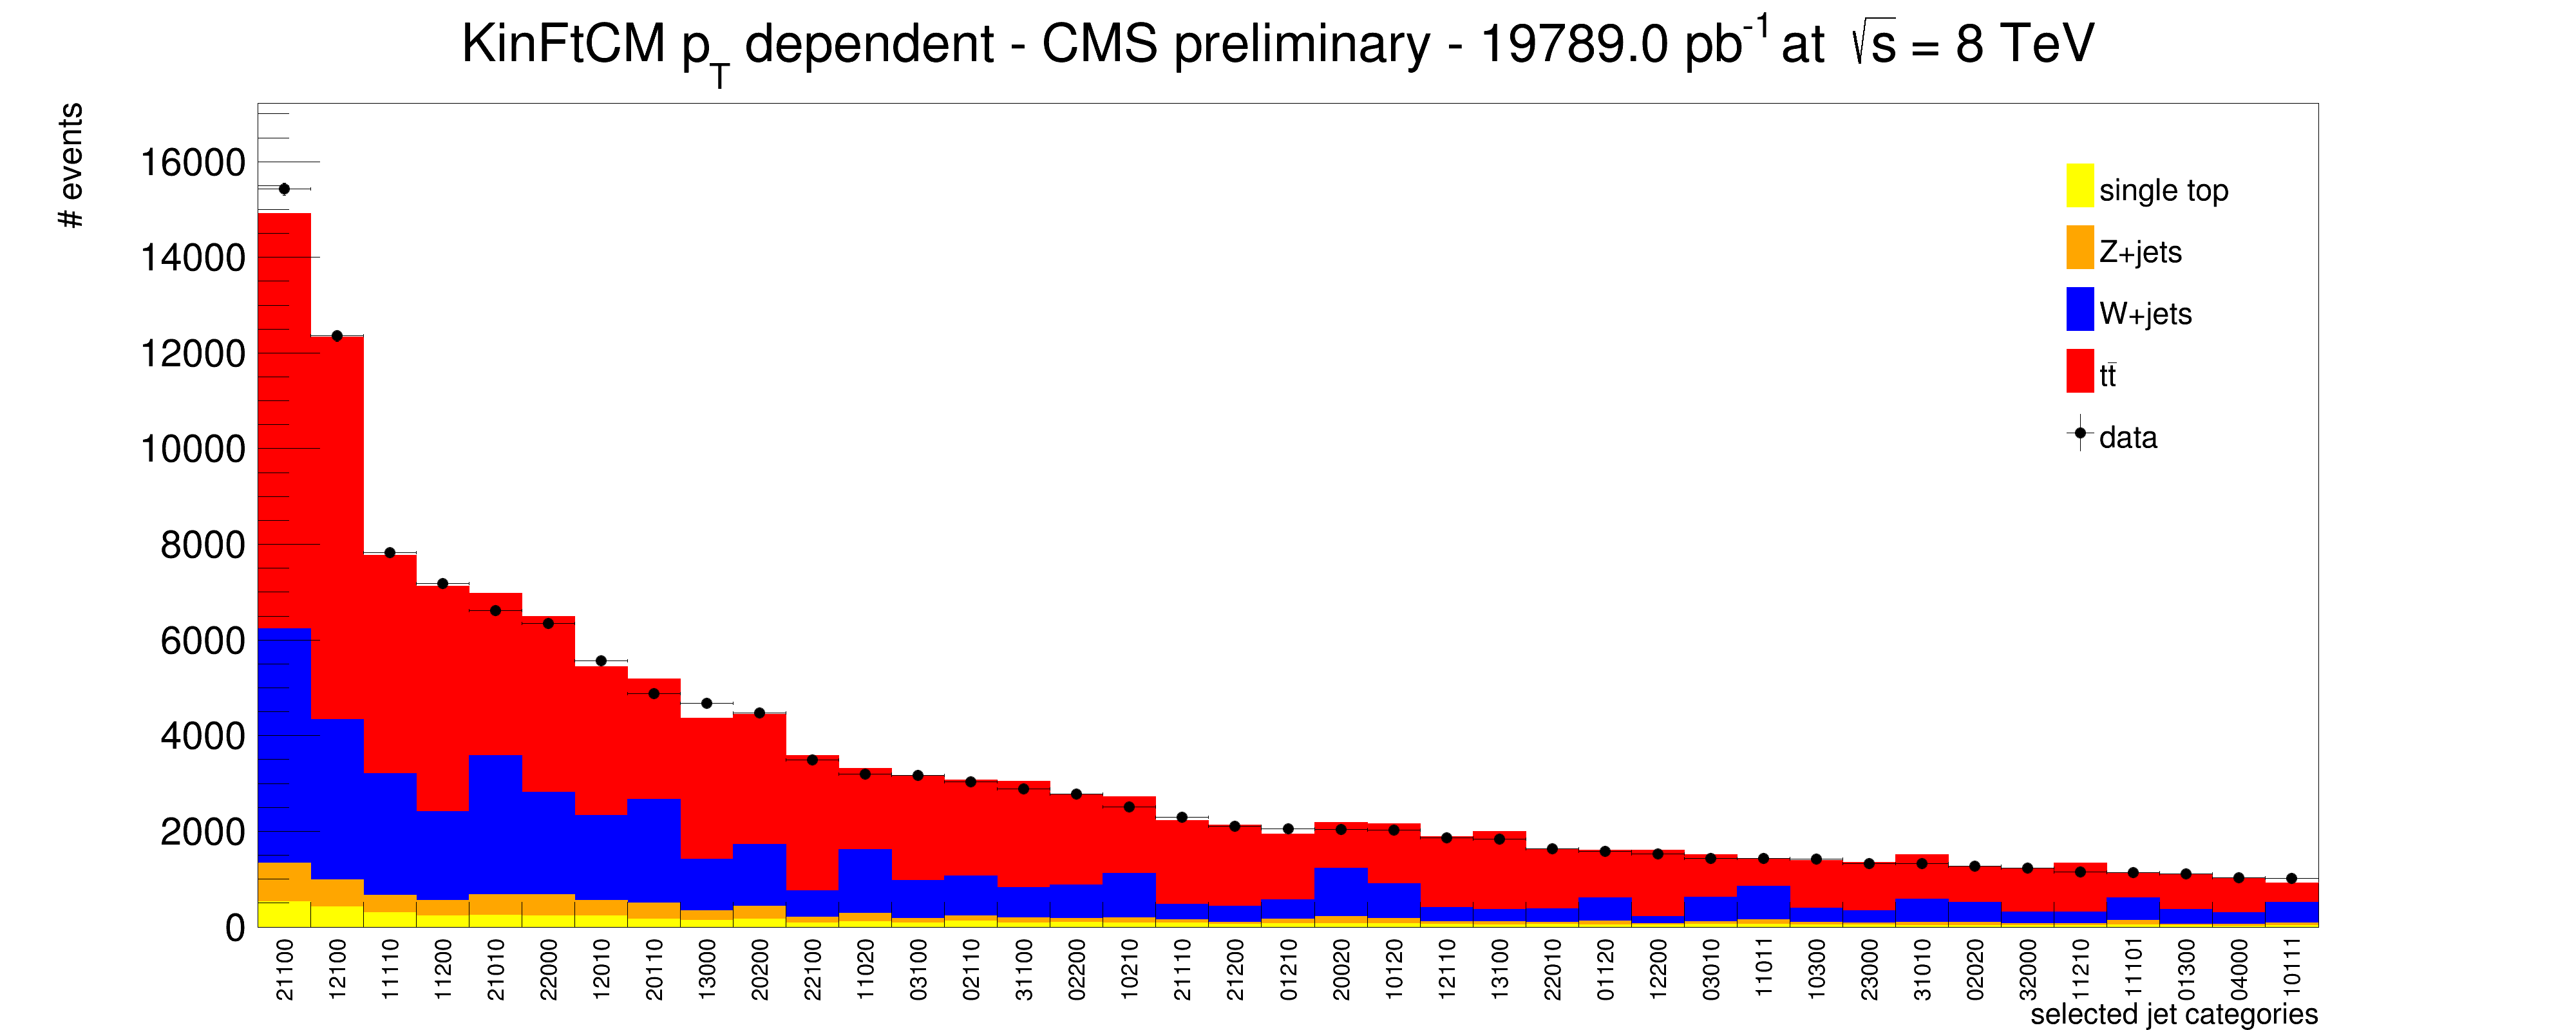

In [17]:
c = Canvas(4000,1600)

h_format = {"data" : [["data"], None, "black", 0],
            "t#bar{t}": [[0],"solid","red", 0],
            "single top": [[3,4,5,6],"solid","yellow", 0],
            "Z+jets": [[2],"solid","orange", 0],
            "W+jets": [[1],"solid","blue",0,"W+jets"]}

bins = range(cats.size()+1)

h_dict = {}
h_stack = HistStack()
legend = Legend(4, leftmargin= 0.70)
legend.SetBorderSize(0)
legend.SetTextFont(43)
legend.SetTextSize(50)

for k,v in h_format.items():
    h_dict[k] = Hist( bins, title = k)
    for i, pretag_cat in enumerate(cats):
        h_dict[k].axis().SetBinLabel(i+1,pretag_cat)
        h_dict[k].SetXTitle("Jet Multiplicity per Kinematic Category")
        h_dict[k].SetYTitle("# events")
        data_counts = m.get_data_pretag_counts(pretag_cat)
        mcs_counts = m.get_mcs_pretag_counts(pretag_cat)
        if k == "data":
            h_dict[k][i+1] = (data_counts, sqrt(data_counts))
        else:
            mc_counts = 0.0
            for s_i in v[0]:
                mc_counts += mcs_counts[s_i]
            h_dict[k][i+1] = mc_counts
    h_dict[k].fillstyle = h_format[k][1]
    h_dict[k].fillcolor = h_format[k][2]
    h_dict[k].linecolor = h_format[k][2]
    h_dict[k].linewidth = h_format[k][3]
   


for s in ["single top", "Z+jets","W+jets", "t#bar{t}"]:
    h_stack.Add(h_dict[s])
    legend.AddEntry(h_dict[s], style = "F")

    
h_stack.Draw("'HIST E1 X0")
h_stack.SetTitle("KinFtCM p_{T} dependent "+"- CMS preliminary - {}".format(lumi) + " pb^{-1} at #sqrt{s} = 8 TeV ")
h_stack.GetXaxis().LabelsOption("v")
h_stack.GetXaxis().SetTitle("selected jet categories")
h_stack.GetXaxis().SetTitleSize(0.030)
h_stack.GetXaxis().SetTitleOffset(1.8)
h_stack.GetXaxis().SetLabelSize(0.035)
h_stack.GetYaxis().SetTitle("# events")
h_stack.GetYaxis().SetTitleOffset(1.3)
h_stack.GetYaxis().SetLabelSize(0.04)

h_dict["data"].SetMarkerSize(2)
h_stack.SetMaximum(h_stack.GetMaximum()*1.1)
h_dict["data"].Draw("SAME E1")
legend.AddEntry(h_dict["data"], style='LEP')
legend.Draw()

name = "sel_jet_cat_pt_8tev"
c.SaveAs(name+".pdf")
c.SaveAs(name+".root")
c




In [31]:
m.cat_set_.size()

514L

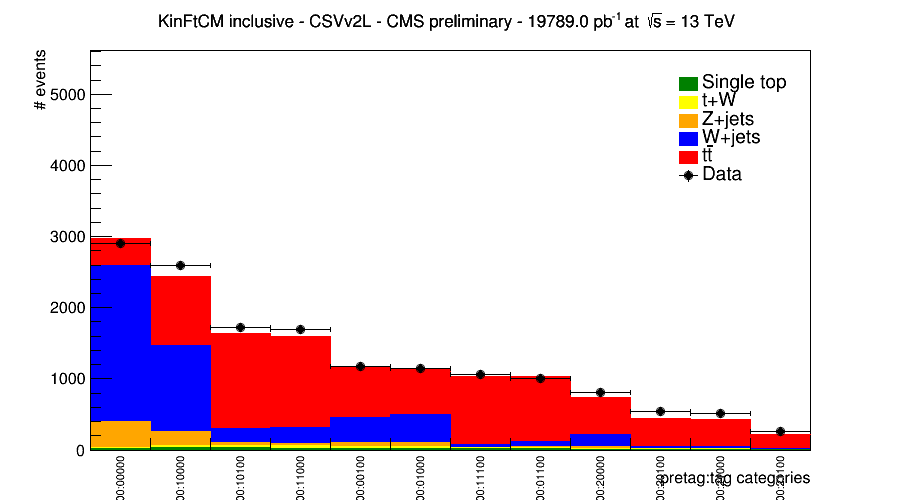

In [33]:
pretag_cat = "21100"

c = Canvas(900,500)

h_format = {"Data" : [["data"], None, "black", 0],
            "t#bar{t}": [[0],"solid","red", 0],
            "Single top": [[3],"solid","green", 0],
            "t+W": [[4,5],"solid","yellow", 0 ],
            "Z+jets": [[2],"solid","orange", 0],
            "W+jets": [[1],"solid","blue",0,"W+jets"]}
tag_cats = m.get_tag_categories(pretag_cat)
bins = range(tag_cats.size()+1)

h_dict = {}
h_stack = HistStack()
legend = Legend(3, leftmargin= 0.65)
legend.SetBorderSize(0)
legend.SetTextFont(43)
legend.SetTextSize(20)

for k,v in h_format.items():
    h_dict[k] = Hist( bins, title = k)
    for i, tag_cat in enumerate(tag_cats):
        h_dict[k].axis().SetBinLabel(i+1,pretag_cat+":"+tag_cat)
        data_counts = m.get_data_tag_counts(pretag_cat,tag_cat)
        mcs_counts = m.get_mcs_tag_counts(pretag_cat,tag_cat)
        if k == "Data":
            h_dict[k][i+1] = (data_counts, sqrt(data_counts))
        else:
            mc_counts = 0.0
            for s_i in v[0]:
                mc_counts += mcs_counts[s_i]
            h_dict[k][i+1] = mc_counts
    h_dict[k].fillstyle = h_format[k][1]
    h_dict[k].fillcolor = h_format[k][2]
    h_dict[k].linecolor = h_format[k][2]
    h_dict[k].linewidth = h_format[k][3]
   


for s in ["Single top", "t+W","Z+jets","W+jets", "t#bar{t}"]:
    h_stack.Add(h_dict[s])
    legend.AddEntry(h_dict[s], style = "F")

h_stack.Draw("'HIST E1 X0")

h_stack.GetXaxis().LabelsOption("v")
h_stack.SetMaximum(h_stack.GetMaximum()*1.8)
h_dict["Data"].Draw("SAME E1")
h_stack.SetTitle("KinFtCM  p_{T} dependent - CSVv2L" + " - CMS preliminary - {}".format(lumi) + " pb^{-1} at #sqrt{s} = 13 TeV ")
h_stack.GetXaxis().SetTitle("pretag:tag categories")
h_stack.GetYaxis().SetTitle("# events")
legend.AddEntry(h_dict["Data"], style='LEP')
legend.Draw()

c

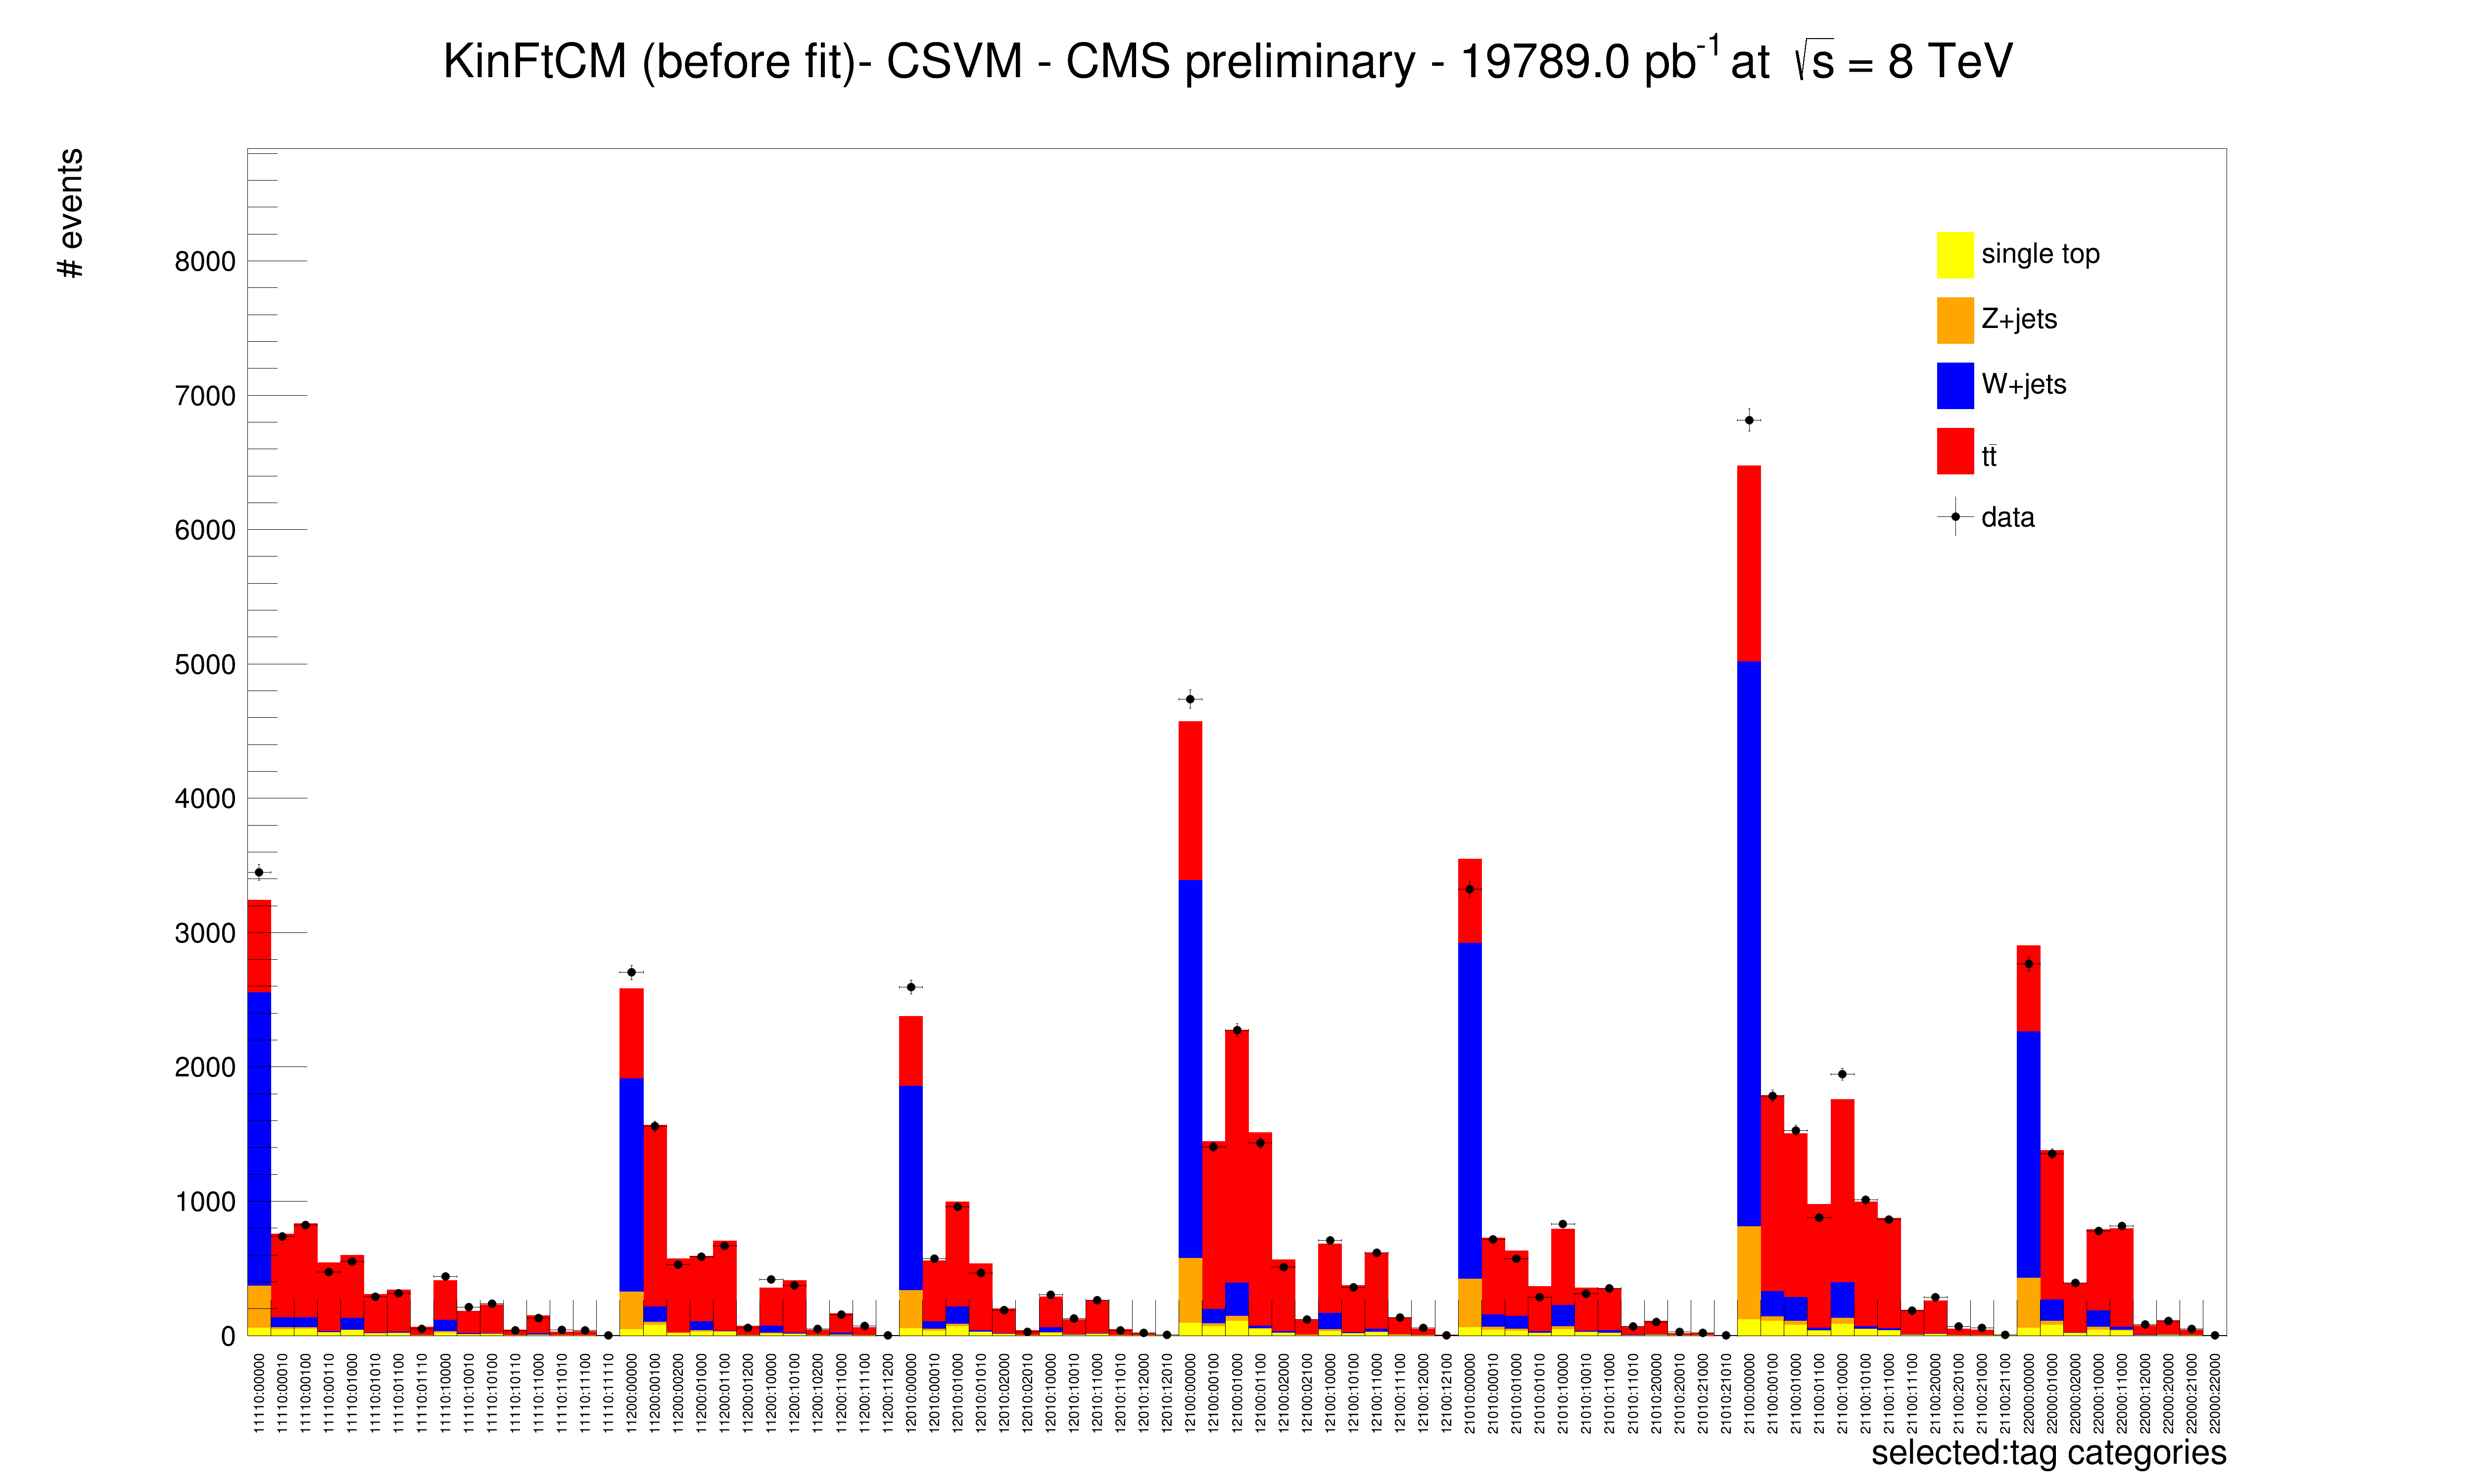

In [26]:


c = Canvas(5000,3000)

h_format = {"data" : [["data"], None, "black", 0],
            "t#bar{t}": [[0],"solid","red", 0],
            "single top": [[3,4,5,6],"solid","yellow", 0],
            "Z+jets": [[2],"solid","orange", 0],
            "W+jets": [[1],"solid","blue",0,"W+jets"]}


pretag_tag_cats = m.cat_set_
bins = range(pretag_tag_cats.size()+1)

h_dict = {}
h_stack = HistStack()
legend = Legend(3, leftmargin= 0.68)
legend.SetBorderSize(0)
legend.SetTextFont(43)
legend.SetTextSize(60)

for k,v in h_format.items():
    h_dict[k] = Hist( bins, title = k)
    for i, tag_cat in enumerate(pretag_tag_cats):
        h_dict[k].axis().SetBinLabel(i+1,tag_cat.first+":"+tag_cat.second)
        data_counts = m.get_data_tag_counts(tag_cat.first,tag_cat.second)
        mcs_counts = m.get_mcs_tag_counts(tag_cat.first,tag_cat.second)
        if k == "data":
            h_dict[k][i+1] = (data_counts, sqrt(data_counts))
        else:
            mc_counts = 0.0
            for s_i in v[0]:
                mc_counts += mcs_counts[s_i]
            h_dict[k][i+1] = mc_counts
    h_dict[k].fillstyle = h_format[k][1]
    h_dict[k].fillcolor = h_format[k][2]
    h_dict[k].linecolor = h_format[k][2]
    h_dict[k].linewidth = h_format[k][3]
   


for s in ["single top", "Z+jets","W+jets", "t#bar{t}"]:
    h_stack.Add(h_dict[s])
    legend.AddEntry(h_dict[s], style = "F")

h_stack.Draw("'HIST E1 X0")

h_stack.GetXaxis().LabelsOption("v")
h_stack.GetXaxis().SetLabelSize(0.030)
h_stack.SetMaximum(h_stack.GetMaximum()*1.3)
h_dict["data"].Draw("SAME E1")
legend.AddEntry(h_dict["data"], style='LEP')
if fit_status == "afit":
    h_stack.SetTitle("KinFtCM (after fit)"+"- {}".format(s_name) + " - CMS preliminary - {}".format(lumi) + " pb^{-1} at #sqrt{s} = 8 TeV ")
else:
    h_stack.SetTitle("KinFtCM (before fit)"+"- {}".format(s_name) + " - CMS preliminary - {}".format(lumi) + " pb^{-1} at #sqrt{s} = 8 TeV ")

    
h_stack.GetXaxis().SetTitle("selected:tag categories")
h_stack.GetYaxis().SetTitle("# events")
h_stack.GetYaxis().SetLabelSize(0.02)
h_stack.GetXaxis().SetLabelSize(0.015)
h_stack.GetYaxis().SetTitleSize(0.025)
h_stack.GetYaxis().SetTitleOffset(1.8)

h_dict["data"].SetMarkerSize(2)



h_stack.GetXaxis().SetTitleSize(0.025)
h_stack.GetXaxis().SetTitleOffset(2.0)

legend.Draw()

c.SaveAs("tag_jet_cat_pt_8tev_{}_{}{}.pdf".format(s_name, fit_status, option))
c.SaveAs("tag_jet_cat_pt_8tev_{}_{}{}.root".format(s_name, fit_status, option))
c

In [23]:

fit_status = "afit"
root_file = root_open("{}fit_result_{}_{}{}.root".format(dir_path, tagger, wp,option))
fit_result = root_file.fitresult_sim_kin_pdf_data_hist
i_pars = fit_result.floatParsInit()
f_pars = fit_result.floatParsFinal()
c_pars = fit_result.constPars()

m.c_jet_tag_effs_.Print("v")
m.b_jet_tag_effs_.Print("v")
m.l_jet_tag_effs_.Print("v")

for n_bin in range(m.b_jet_tag_effs_.getSize()):
    m.c_jet_tag_effs_[n_bin].setVal(c_pars[c_pars.index("c_tag_eff_{}".format(n_bin))].getVal())
    m.l_jet_tag_effs_[n_bin].setVal(c_pars[c_pars.index("l_tag_eff_{}".format(n_bin))].getVal())
    m.b_jet_tag_effs_[n_bin].setVal(f_pars[f_pars.index("b_tag_eff_{}".format(n_bin))].getVal())

m.xsecs_[0].setVal(f_pars[f_pars.index("xsec_"+mc_names[0][0])].getVal())
m.kappa_.setVal(f_pars[f_pars.index("kappa")].getVal())

m.c_jet_tag_effs_.Print("v")
m.b_jet_tag_effs_.Print("v")
m.l_jet_tag_effs_.Print("v")

In [25]:
fit_status = "bfit"
root_file = root_open("{}fit_result_{}_{}{}.root".format(dir_path, tagger, wp,option))
fit_result = root_file.fitresult_sim_kin_pdf_data_hist
i_pars = fit_result.floatParsInit()
f_pars = fit_result.floatParsFinal()
c_pars = fit_result.constPars()

m.c_jet_tag_effs_.Print("v")
m.b_jet_tag_effs_.Print("v")
m.l_jet_tag_effs_.Print("v")

for n_bin in range(m.b_jet_tag_effs_.getSize()):
    m.c_jet_tag_effs_[n_bin].setVal(c_pars[c_pars.index("c_tag_eff_{}".format(n_bin))].getVal())
    m.l_jet_tag_effs_[n_bin].setVal(c_pars[c_pars.index("l_tag_eff_{}".format(n_bin))].getVal())
    m.b_jet_tag_effs_[n_bin].setVal(i_pars[i_pars.index("b_tag_eff_{}".format(n_bin))].getVal())

m.xsecs_[0].setVal(i_pars[i_pars.index("xsec_"+mc_names[0][0])].getVal())
m.kappa_.setVal(i_pars[i_pars.index("kappa")].getVal())

m.c_jet_tag_effs_.Print("v")
m.b_jet_tag_effs_.Print("v")